In [1]:
import numpy as np
import pandas as pd
%matplotlib inline

In [26]:
import tqdm
import glob, os, pickle
dfs=[]
path= "/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Sophie_Chen/scc_tumor_data/prelim_patch_info_v2/"

for file in tqdm.tqdm(sorted(glob.glob(path + '/*.pkl'))):
    basename=os.path.basename(file).replace(".pkl","")
    df=pd.read_pickle(file)
    df['patch_index']=np.arange(df.shape[0])
    if 'scc' not in df.columns: df['scc']=0
    df['scc']=(df['scc']==1).astype(int)  
    df['ID']=basename
    dfs.append(df)
df=pd.concat(dfs)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 95/95 [00:05<00:00, 16.66it/s]


In [29]:
from sklearn.model_selection import train_test_split

In [30]:
TUMOR_THRESHOLD=0.2
IDs=(df.groupby(["ID"])['scc'].mean()>TUMOR_THRESHOLD).astype(int)

In [31]:

train_ID,test_ID=train_test_split(IDs,stratify=IDs.values, random_state=42)
train_ID,val_ID=train_test_split(train_ID,stratify=train_ID.values, random_state=42)

In [32]:
train_val_test_slide_ids=dict(train=train_ID.index,val=val_ID.index,test=test_ID.index)

In [33]:
np.random.seed(42)
patch_dict=dict(train=df.loc[df['ID'].isin(train_val_test_slide_ids['train'])].sample(n=1280),
               val=df.loc[df['ID'].isin(train_val_test_slide_ids['val'])].sample(n=512),
               test=df.loc[df['ID'].isin(train_val_test_slide_ids['test'])].sample(n=512))

In [34]:
train_val_test_slide_ids={k:patch_dict[k]['ID'].unique() for k in patch_dict}

In [10]:
train_val_test_slide_ids

{'train': array(['368_A1d_ASAP_tumor_map', '350_A1e_ASAP_tumor_map',
        '364_A1b_ASAP_tumor_map', '354_A1d_ASAP_tumor_map',
        '12_A1c_ASAP_tumor_map', '354_A3b_ASAP_tumor_map',
        '365_A2b_ASAP_tumor_map', '7_A1e_ASAP_tumor_map',
        '341_a_ASAP_tumor_map', '10_A1b_ASAP_tumor_map',
        '123_A1a_ASAP_tumor_map', '353_A2b_ASAP_tumor_map',
        '7_A1d_ASAP_tumor_map', '363_A3b_ASAP_tumor_map',
        '365_A1b_ASAP_tumor_map', '112_a_ASAP_tumor_map',
        '270_A1d_ASAP_tumor_map', '358_A1b_ASAP_tumor_map',
        '344_a_ASAP_tumor_map', '369_A2b_ASAP_tumor_map',
        '346_b_ASAP_tumor_map', '368_A1c_ASAP_tumor_map',
        '281_A1f_ASAP_tumor_map', '270_A1e_ASAP_tumor_map',
        '343_c_ASAP_tumor_map', '352_A1d_ASAP_tumor_map',
        '355_A1d_ASAP_tumor_map', '354_A1b_ASAP_tumor_map',
        '342_a_ASAP_tumor_map', '61_B1a_ASAP_tumor_map',
        '352_A1e_ASAP_tumor_map', '7_A1c_ASAP_tumor_map',
        '354_A3c_ASAP_tumor_map', '350_A1d_ASAP_tumo

In [35]:
df['Set']='train'
for k in train_val_test_slide_ids:
    df.loc[df["ID"].isin(train_val_test_slide_ids[k]),"Set"]=k

In [36]:

df.to_pickle("master1_dict.pkl")

In [37]:
for k in tqdm.tqdm(list(patch_dict.keys()),desc="train_val_test"):
    if not os.path.exists(f'cnn_model_input1/{k}_data.pkl'):
        X,y=[],[]
        for name, dff in tqdm.tqdm(patch_dict[k].groupby('ID'),total=patch_dict[k]['ID'].nunique(),desc="case"):
            arr=np.load(f"/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Sophie_Chen/scc_tumor_data/prelim_patch_info/{name}.npy")
            X.append(arr[dff['patch_index'].values])
            y.append(dff['scc'].values.flatten().astype(int))
            del arr
        X=np.concatenate(X,0)
        y=np.hstack(y)
        with open(f'/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Sophie_Chen/scc_tumor_data/prelim_patch_info//{k}_data.pkl','wb') as f:
            pickle.dump(dict(X=X,y=y,patch_info=patch_dict[k]),f,pickle.HIGHEST_PROTOCOL)

train_val_test: 100%|██████████████████████████████████████████████████████████████████████████| 3/3 [18:39<00:00, 373.07s/it]


In [ ]:
#! ls /dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Sophie_Chen/scc_tumor_data/prelim_patch_info/

In [ ]:
#! ls cnn_model_input

In [ ]:
#! pip install scikit-learn==0.24.2 --force-reinstall --no-deps

In [ ]:
#import pandas as pd
#d=pd.read_pickle("/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Sophie_Chen/scc_tumor_data/prelim_patch_info/train_data.pkl")

In [ ]:
#from keras.utils import to_categorical
#d['y']=to_categorical(d['y'])


In [ ]:
#d['y'].shape

In [ ]:
from keras.callbacks import ReduceLROnPlateau
lrr=ReduceLROnPlateau (monitor='val_acc', factor=.01, patience=3, min_lr=1e-5)

In [1]:
from pathpretrain.train_model import train_model
train_model(inputs_dir="/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Sophie_Chen/cnn_model_input/",
                learning_rate=1e-4,
                n_epochs=100,
                batch_size=32,
                model_save_loc='/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Sophie_Chen/cnn_tttttmodel.pkl',
                verbose=2,
                class_balance=True,
                predict=False,
                pickle_dataset=True)

KeyboardInterrupt: 

In [2]:
from pathpretrain.predict import predict

In [12]:
predict(inputs_dir='/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Sophie_Chen/cnn_model_input/',
                batch_size=64,
                model_save_loc="/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Sophie_Chen/cnn_model.pkl",
                predict_set='test',
                pickle_dataset=True)

{'train': <pathpretrain.datasets.PickleDataset object at 0x2aee1af59340>, 'val': <pathpretrain.datasets.PickleDataset object at 0x2aee1af599d0>, 'test': <pathpretrain.datasets.PickleDataset object at 0x2aee1af7cd60>}
ResNet(
  (features): Sequential(
    (init_block): ResInitBlock(
      (conv): ConvBlock(
        (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activ): ReLU(inplace=True)
      )
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (stage1): Sequential(
      (unit1): ResUnit(
        (body): ResBottleneck(
          (conv1): ConvBlock(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (activ): ReLU(inplace=True)
          )
          (conv2): Conv

100%|█████████████████████████████████████████████| 8/8 [00:02<00:00,  3.97it/s]


In [15]:
import torch
from scipy.special import softmax
from sklearn.metrics import roc_auc_score
predictions=torch.load("/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Sophie_Chen/predictions.pkl")
predictions['pred']=softmax(predictions['pred'])
roc_auc_score(predictions['true'],predictions['pred'][:,1])

0.9070135746606336

In [2]:
from pathpretrain.embed import generate_embeddings

In [3]:
 generate_embeddings(patch_info_file="/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Sophie_Chen/scc_tumor_data/prelim_patch_info_v2/311_A2c_ASAP_tumor_map.pkl",
                     image_file="/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Sophie_Chen/scc_tumor_data/prelim_patch_info/311_A2c_ASAP_tumor_map.npy",
                     model_save_loc='"/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Sophie_Chen/cnn_model.pkl"',
                     architecture='resnet50',
                     num_classes=2,
                     image_stack=True)
                   

386it [00:37, 10.43it/s]                                                                       


In [2]:
import torch
embeddings=torch.load("/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Sophie_Chen/cnn_embeddings/368_A1b_ASAP_tumor_map.pkl")

In [3]:
import umap 
z=umap.UMAP(random_state=42, n_components=2).fit_transform(embeddings['embeddings'])

2022-09-10 23:27:35.264725: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


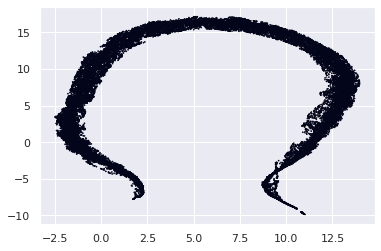

In [10]:
import matplotlib, matplotlib.pyplot as plt
plt.scatter(z[:,0],z[:,1],c=embeddings['patch_info']['scc'],s=0.5)

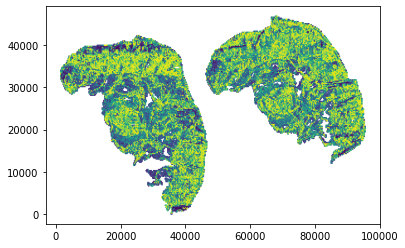

In [5]:
plt.scatter(embeddings['patch_info']['x'],embeddings['patch_info']['y'],c=z[:,1], s=0.4)


In [1]:
import pandas as pd
df=pd.read_pickle("/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Sophie_Chen/master1_dict.pkl")

In [2]:
from pathpretrain.embed import generate_embeddings
for ID in df['ID'].unique():
    generate_embeddings(patch_info_file=f"/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Sophie_Chen/scc_tumor_data/prelim_patch_info_v2/{ID}.pkl",
                        image_file=f"/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Sophie_Chen/scc_tumor_data/prelim_patch_info/{ID}.npy",
                        model_save_loc='cnn_model.pkl',
                        architecture="resnet50",
                        num_classes=3,
                        image_stack=True)

1291it [01:58, 10.90it/s]                                                                      
515it [00:49, 10.39it/s]                                                                       
532it [00:46, 11.35it/s]                                                                       
576it [00:51, 11.08it/s]                                                                       
100%|████████████████████████████████████████████████████████| 558/558 [00:54<00:00, 10.21it/s]
195it [00:18, 10.65it/s]                                                                       
214it [00:19, 10.70it/s]                                                                       
500it [00:45, 10.90it/s]                                                                       
654it [00:51, 12.64it/s]                                                                       
457it [00:44, 10.21it/s]                                                                       
462it [00:36, 12.83it/s]                